In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score

In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [4]:
data = pd.read_csv('data.csv')
data.drop('Unnamed', axis=1, inplace=True)
replace_class = {1:1, 2:2, 3:3, 4:4, 5:5}
data['y'] = data['y'].replace(replace_class)

In [5]:
X = data.drop('y', axis=1)
y = data['y']

In [6]:
print(type(X), type(y))
print(X.shape, y.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(11500, 178) (11500,)


In [7]:
X = X.values
y = y.values
print(type(X), type(y))
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(11500, 178) (11500,)


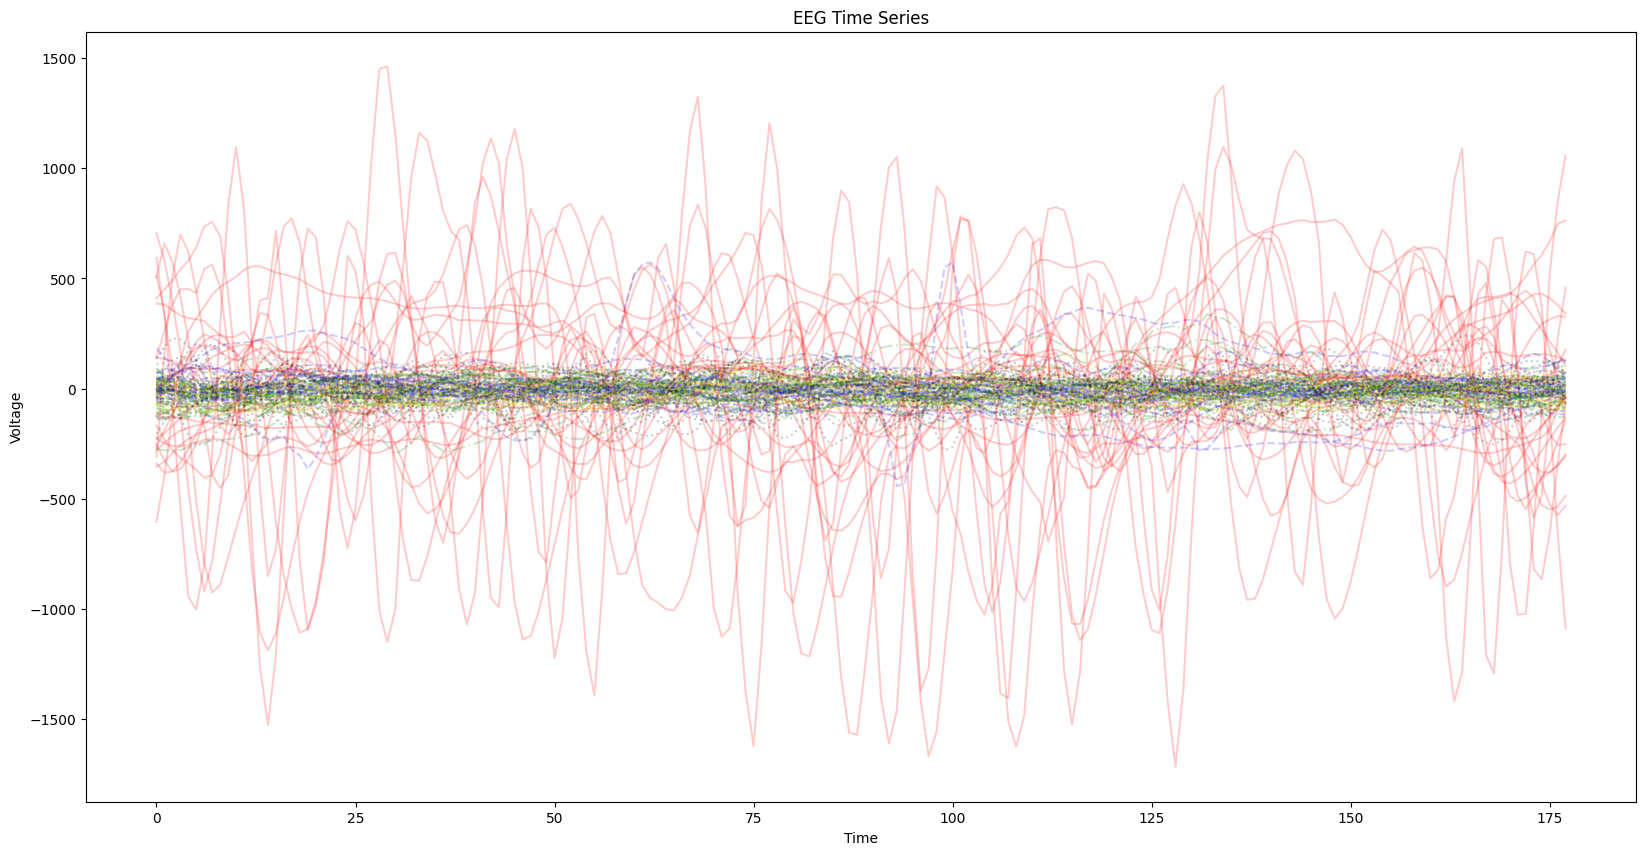

In [10]:
# plot the time series
plt.figure(figsize=(20,10))
num_samples = data.shape[0]
limit = 25
count = 0
for i in range(num_samples):
    if count <= limit:
        if y[i] == 1:
            plt.plot(X[i], color='red', alpha=0.2)
            count += 1
    else:
        break
# plt.show()

count = 0
for i in range(num_samples):
    if count <= limit:
        if y[i] == 2:
            plt.plot(X[i], linestyle='--', color='blue', alpha=0.2)
            count += 1
    else:
        break

count = 0
for i in range(num_samples):
    if count <= limit:
        if y[i] == 3:
            plt.plot(X[i], linestyle='-.', color='green', alpha=0.2)
            count += 1
    else:
        break

count = 0
for i in range(num_samples):
    if count <= limit:
        if y[i] == 4:
            plt.plot(X[i], linestyle=':', color='black', alpha=0.2)
            count += 1
    else:
        break

count = 0
for i in range(num_samples):
    if count <= limit:
        if y[i] == 5:
            plt.plot(X[i], linestyle=':', color='yellow', alpha=0.2)
            count += 1
    else:
        break

plt.title('EEG Time Series')
plt.ylabel('Voltage')
plt.xlabel('Time')
plt.savefig('sample_time_series.png')
plt.show()

## FFT

In [48]:
X = np.fft.rfft(X, axis=1)
X = np.abs(X)
print(X.shape)
print(X[0][:5])

(11500, 90)
[3010.         2487.87450966 3042.670412   4575.54039151 2968.23505463]


### Normalize

In [35]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
print(X.shape)
print(X[0][:5])

In [49]:
clf_list = {"xgb": xgb.XGBClassifier(learning_rate=0.3, n_estimators=300), 
            "rfc": RandomForestClassifier(criterion='gini', n_estimators=300), 
            "dtc": DecisionTreeClassifier(criterion='entropy', max_features='log2'), 
            "lr": LogisticRegression(max_iter=1000, C=3.0, penalty='l1', solver='liblinear'), 
            "svc": SVC(C=3.0, probability=True)}

In [50]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8050, 90) (3450, 90)
(8050,) (3450,)


In [51]:
# train classifier
for i in clf_list:
    clf = clf_list[i]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(clf.__class__.__name__, i, "%.2f%%" % (accuracy * 100.0))

XGBClassifier xgb 98.17%
RandomForestClassifier rfc 98.06%
DecisionTreeClassifier dtc 94.70%
LogisticRegression lr 97.48%
SVC svc 98.64%


In [52]:
# Convert your data into torch tensors
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Create DataLoaders
batch_size = 10
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Define the network architecture
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layer_1 = nn.Linear(X_train.shape[1], 64)
        self.layer_2 = nn.Linear(64, 16)
        self.layer_out = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(16)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        # x = self.dropout(x)
        x = self.layer_out(x)
        
        return torch.sigmoid(x)

# Initialize the model, optimizer and loss function
model = BinaryClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Train the model
model.train()
for epoch in range(50):  # number of epochs
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels.view(-1, 1))
        
        # Backward propagation and optimization
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.view(-1, 1)).sum().item()

print('Accuracy: %.2f%%' % (100 * correct / total))


Accuracy: 97.71%


# Plot ROC curve and Precision-Recall curve

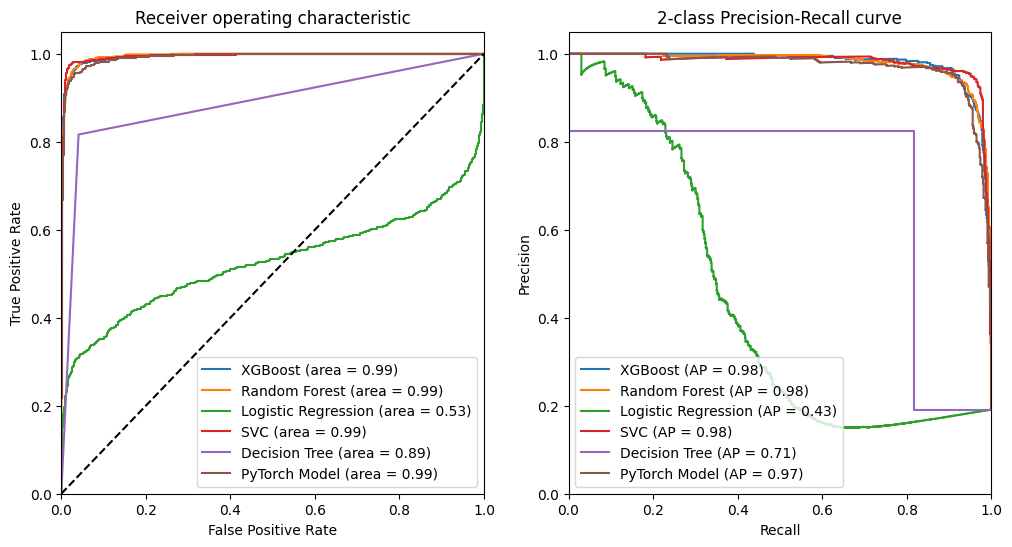

In [31]:
# y_test is your ground truth and y_pred is model's predicted probabilities.
# For XGBoost
y_pred_xgb = clf_list['xgb'].predict_proba(X_test)[:,1]

# For Random Forest
y_pred_rf = clf_list['rfc'].predict_proba(X_test)[:,1]

# For Logistic Regression
y_pred_lr = clf_list['lr'].predict_proba(X_test)[:,1]

# For SVM
y_pred_svc = clf_list['svc'].predict_proba(X_test)[:,1]

# For Decision Tree
y_pred_dtc = clf_list['dtc'].predict_proba(X_test)[:,1]

# For PyTorch Model
model.eval()
with torch.no_grad():
    y_pred_torch = model(torch.Tensor(X_test))
y_pred_torch = y_pred_torch.detach().numpy()

# For plotting ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# ROC curve
for clf, y_pred, label in zip([clf_list['xgb'], clf_list['rfc'], clf_list['lr'], clf_list['svc'], clf_list['dtc'], model], 
                              [y_pred_xgb, y_pred_rf, y_pred_lr, y_pred_svc, y_pred_dtc, y_pred_torch], 
                              ['XGBoost', 'Random Forest', 'Logistic Regression', 'SVC', 'Decision Tree', 'PyTorch Model']):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver operating characteristic')
ax1.legend(loc="lower right")

# Precision-Recall curve
for clf, y_pred, label in zip([clf_list['xgb'], clf_list['rfc'], clf_list['lr'], clf_list['svc'], clf_list['dtc'], model], 
                              [y_pred_xgb, y_pred_rf, y_pred_lr, y_pred_svc, y_pred_dtc, y_pred_torch], 
                              ['XGBoost', 'Random Forest', 'Logistic Regression', 'SVC', 'Decision Tree', 'PyTorch Model']):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    ax2.step(recall, precision, where='post', label=f'{label} (AP = {average_precision:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_ylim([0.0, 1.05])
ax2.set_xlim([0.0, 1.0])
ax2.set_title('2-class Precision-Recall curve')
ax2.legend(loc="lower left")
plt.savefig('roc_pr_curve.png')
plt.show()

Very promising results!
To push it a step further, you can consider the method here: https://github.com/MichaelHills/seizure-detection
This person applied a fast Fourier transform to the data before training on a random forest classifier, which gave him results good enough to win a Kaggle competition (granted, this was many years ago).
Another thing you can potentially look into is using labels 4 and 5 as covariates. For example, if the EEG of seizure patients look calmer when their eyes are closed, then including this information may help your model not misclassify the patient as being healthy.